In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. 데이터 로드 및 필터링
df = pd.read_csv('../../../data/blinkit-dataset/blinkit_master_data_eda_mk_251224.csv', parse_dates=['order_date'])
dairy_df = df[df['category'] == 'Dairy & Breakfast'].copy()

# 2. 일별 데이터로 리샘플링 (Target: quantity의 합계)
daily_data = dairy_df.groupby('order_date').agg({
    'quantity': 'sum',
    'price': 'mean',
    'mrp': 'mean',
    'delivery_time_minutes': 'mean',
    'rating': 'mean'
}).reset_index()

# 3. Feature Engineering
def create_features(df):
    df = df.sort_values('order_date')
    
    # 시간 관련 피처
    df['dayofweek'] = df['order_date'].dt.dayofweek
    df['quarter'] = df['order_date'].dt.quarter
    df['month'] = df['order_date'].dt.month
    df['dayofmonth'] = df['order_date'].dt.day
    df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # 가격/할인율 피처
    df['discount_rate'] = (df['mrp'] - df['price']) / df['mrp']
    
    # Lag 피처 (과거 수요가 미래에 미치는 영향)
    for lag in [1, 7, 14]:
        df[f'lag_{lag}'] = df['quantity'].shift(lag)
    
    # Rolling 피처 (최근 트렌드)
    df['rolling_mean_7'] = df['quantity'].shift(1).rolling(window=7).mean()
    df['rolling_std_7'] = df['quantity'].shift(1).rolling(window=7).std()
    
    return df

daily_features = create_features(daily_data).dropna()

# 4. 학습/테스트 데이터 분리 (시계열 특성상 Shuffle 금지)
X = daily_features.drop(['order_date', 'quantity'], axis=1)
y = daily_features['quantity']

# 마지막 30일을 테스트셋으로 사용
split_date = daily_features['order_date'].max() - pd.Timedelta(days=30)
X_train = X[daily_features['order_date'] <= split_date]
y_train = y[daily_features['order_date'] <= split_date]
X_test = X[daily_features['order_date'] > split_date]
y_test = y[daily_features['order_date'] > split_date]

# 5. Random Forest 모델 학습
rf_model = RandomForestRegressor(
    n_estimators=200, 
    max_depth=10, 
    random_state=42,
    n_jobs=-1  # 맥북의 성능을 활용하기 위해 병렬 처리 설정
)

rf_model.fit(X_train, y_train)

# 6. 결과 확인
predictions = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"Random Forest 평가 결과 -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Random Forest 평가 결과 -> MAE: 1.81, RMSE: 2.67


### 시각화

/var/folders/qr/t17kbzk509lf9_ysbrz802qw0000gn/T/ipykernel_98279/185185241.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled = cat_df.groupby(pd.Grouper(key='order_date', freq=freq)).agg({


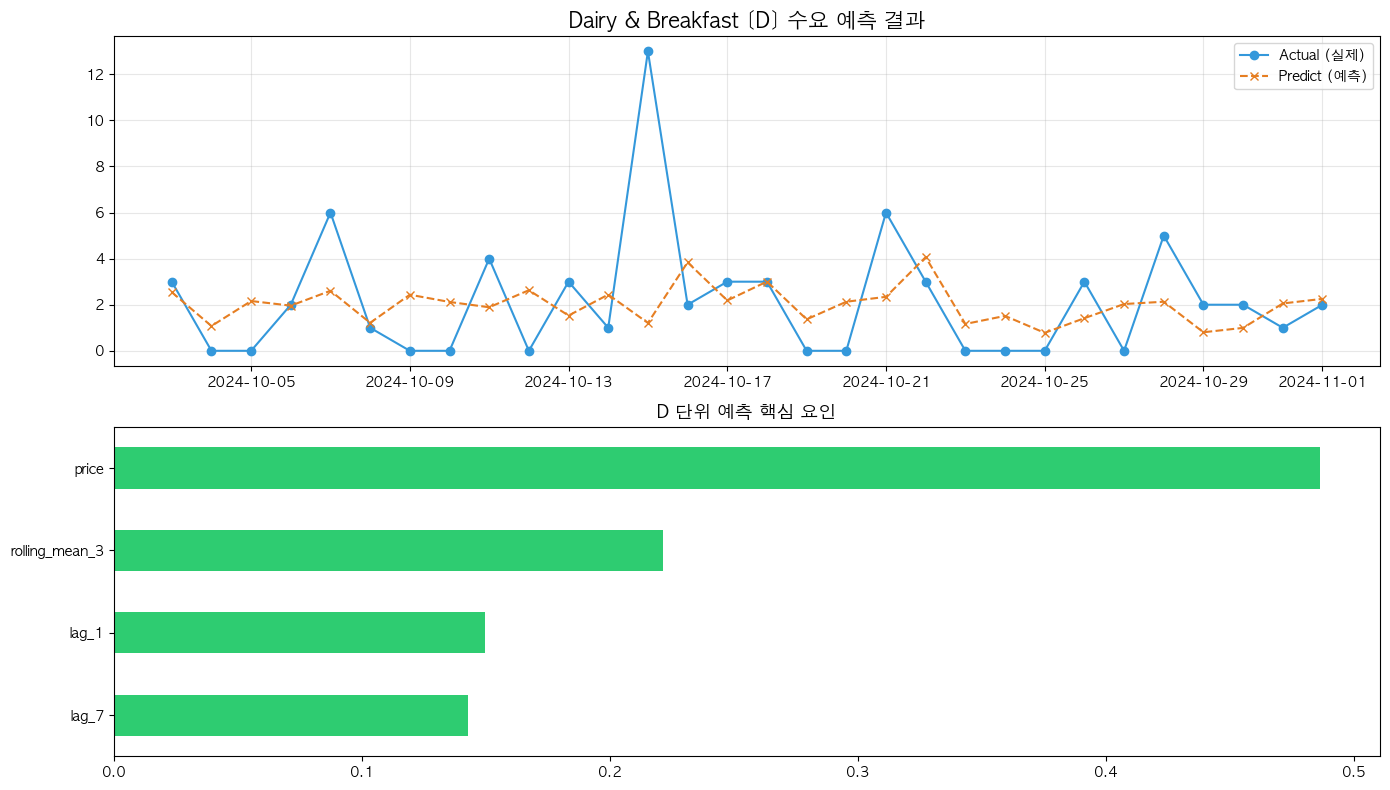

--- Dairy & Breakfast (D) 결과 ---
평균 절대 오차(MAE): 1.86



/var/folders/qr/t17kbzk509lf9_ysbrz802qw0000gn/T/ipykernel_98279/185185241.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled = cat_df.groupby(pd.Grouper(key='order_date', freq=freq)).agg({


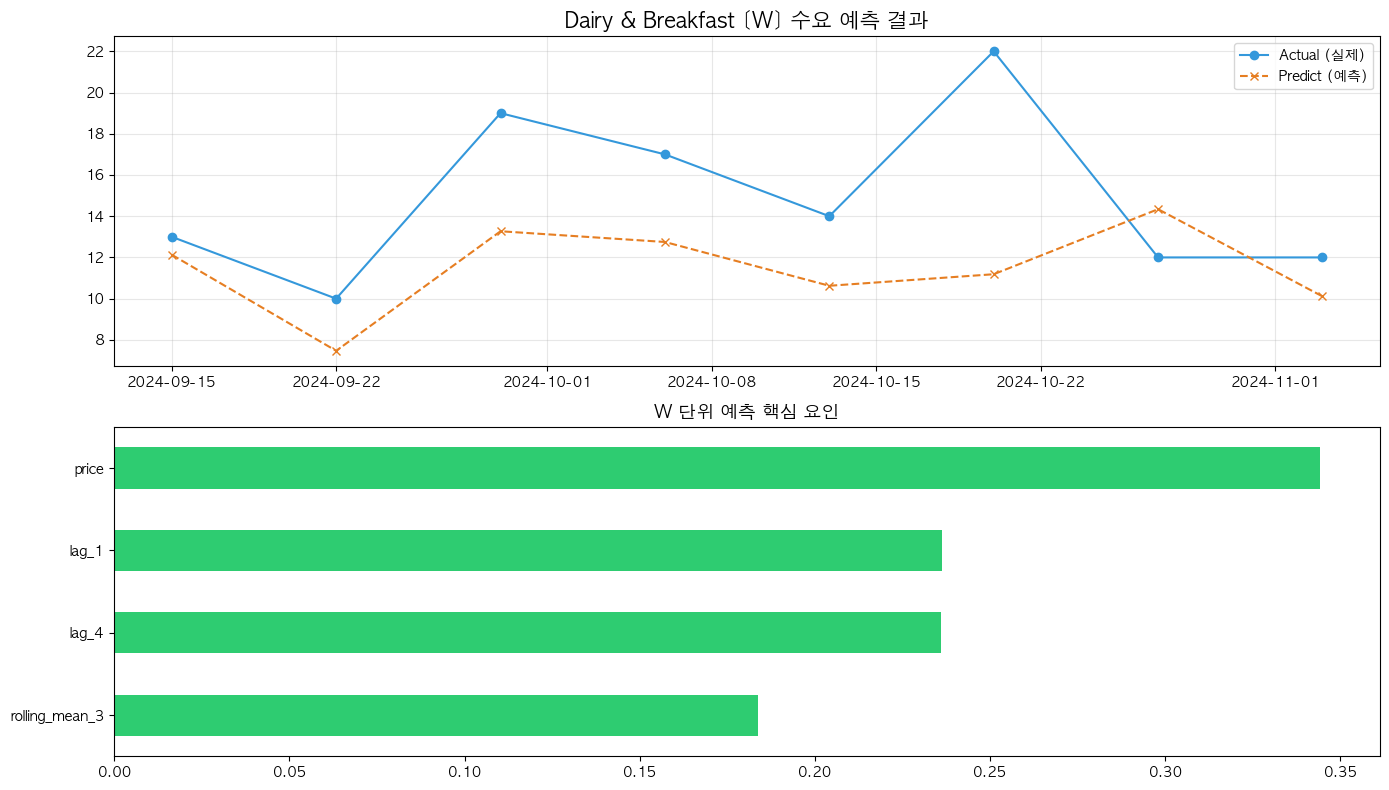

--- Dairy & Breakfast (W) 결과 ---
평균 절대 오차(MAE): 3.98



/var/folders/qr/t17kbzk509lf9_ysbrz802qw0000gn/T/ipykernel_98279/185185241.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = cat_df.groupby(pd.Grouper(key='order_date', freq=freq)).agg({
/var/folders/qr/t17kbzk509lf9_ysbrz802qw0000gn/T/ipykernel_98279/185185241.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled = cat_df.groupby(pd.Grouper(key='order_date', freq=freq)).agg({


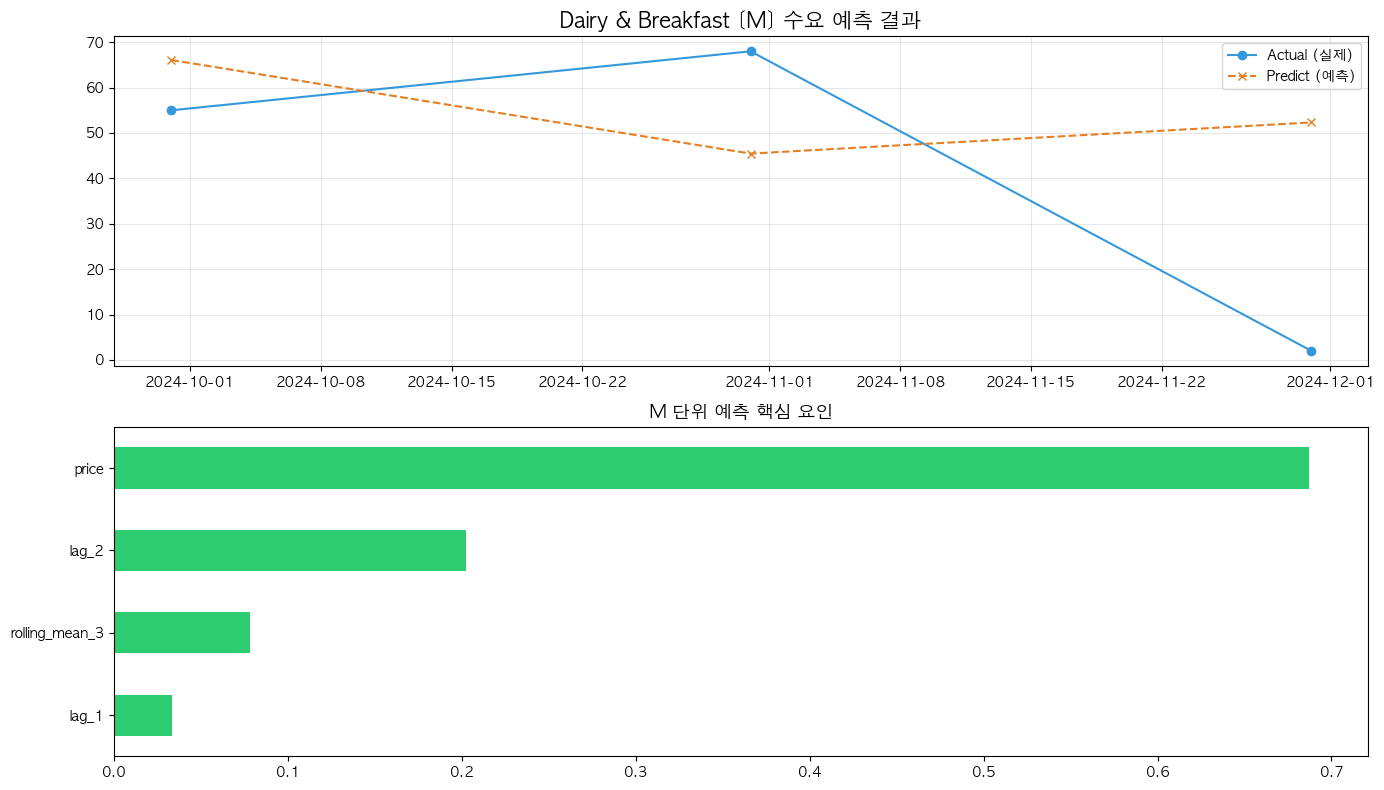

--- Dairy & Breakfast (M) 결과 ---
평균 절대 오차(MAE): 27.98



In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# [중요] 맥북 한글 깨짐 방지 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드 및 초기 설정
df = pd.read_csv('../../../data/blinkit-dataset/blinkit_master_data_eda_mk_251224.csv', parse_dates=['order_date'])
# 데이터 내 실제 카테고리명: 'Dairy & Breakfast' 혹은 'Instant & Frozen Food' (Breakfast 대용)
MY_CATEGORY = 'Dairy & Breakfast' 

def run_demand_forecast(full_df, category_name, freq='D'):
    """
    freq: 'D' (Daily), 'W' (Weekly), 'M' (Monthly)
    """
    # A. 카테고리 필터링
    cat_df = full_df[full_df['category'] == category_name].copy()
    if len(cat_df) == 0:
        print(f"'{category_name}' 카테고리에 데이터가 없습니다.")
        return
    
    # B. 주기별 데이터 집계
    resampled = cat_df.groupby(pd.Grouper(key='order_date', freq=freq)).agg({
        'quantity': 'sum',
        'price': 'mean'
    }).reset_index().fillna(method='ffill')

    # C. Feature Engineering
    df_feat = resampled.copy()
    # 주기별 최적화된 Lag 설정
    lags = [1, 7] if freq == 'D' else ([1, 4] if freq == 'W' else [1, 2])
    for lag in lags:
        df_feat[f'lag_{lag}'] = df_feat['quantity'].shift(lag)
    
    df_feat['rolling_mean_3'] = df_feat['quantity'].shift(1).rolling(window=3).mean()
    df_feat = df_feat.dropna()
    
    # D. 데이터 분할
    X = df_feat.drop(['order_date', 'quantity'], axis=1)
    y = df_feat['quantity']
    
    # 테스트 사이즈 결정 (전체 데이터의 약 15~20%)
    test_size = 30 if freq == 'D' else (8 if freq == 'W' else 3)
    if len(df_feat) <= test_size: test_size = 1
        
    X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
    y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
    
    # E. 모델 학습 (Random Forest)
    model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    # F. 시각화 (NameError 방지를 위해 직접 category_name 사용)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
    
    # 그래프 1: 실제 vs 예측
    test_dates = resampled['order_date'].iloc[-test_size:]
    ax1.plot(test_dates, y_test, label='Actual (실제)', color='#3498db', marker='o')
    ax1.plot(test_dates, preds, label='Predict (예측)', color='#e67e22', linestyle='--', marker='x')
    ax1.set_title(f'{category_name} [{freq}] 수요 예측 결과', fontsize=15)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 그래프 2: 변수 중요도
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values()
    importances.plot(kind='barh', ax=ax2, color='#2ecc71')
    ax2.set_title(f'{freq} 단위 예측 핵심 요인', fontsize=13)
    
    plt.tight_layout()
    plt.show()
    
    print(f"--- {category_name} ({freq}) 결과 ---")
    print(f"평균 절대 오차(MAE): {mean_absolute_error(y_test, preds):.2f}\n")

# 2. 실행: 일/주/월별 순차적 실행
for f in ['D', 'W', 'M']:
    run_demand_forecast(df, MY_CATEGORY, freq=f)

---

## 월급날, 가격 할인율 feature 추가

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# [설정] 맥북 한글 폰트
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드 및 집계
df = pd.read_csv('../../../data/blinkit-dataset/blinkit_master_data_eda_mk_251224.csv', parse_dates=['order_date'])
target_cat = 'Dairy & Breakfast'
cat_df = df[df['category'] == target_cat].copy()

def build_advanced_features(data, freq='D'):
    # A. 주기별 기본 집계 (할인율 계산을 위해 price와 mrp 포함)
    resampled = data.groupby(pd.Grouper(key='order_date', freq=freq)).agg({
        'quantity': 'sum',
        'price': 'mean',
        'mrp': 'mean',
        'rating': 'mean'
    }).reset_index().fillna(method='ffill')

    # B. 고도화 피처 생성
    # 1) 할인율 (MRP 대비 실제 가격)
    resampled['discount_rate'] = (resampled['mrp'] - resampled['price']) / resampled['mrp']
    
    # 2) 월급날 효과 (매월 25일 전후 2일을 1로 설정)
    # 일별(Daily) 데이터에서 가장 효과가 큼
    resampled['is_payday'] = resampled['order_date'].dt.day.apply(lambda x: 1 if x in [24, 25, 26] else 0)
    
    # 3) 월초/월말 효과 (장보기 수요)
    resampled['is_month_end'] = resampled['order_date'].dt.is_month_end.astype(int)
    
    # 4) 시간 관련 피처
    resampled['dayofweek'] = resampled['order_date'].dt.dayofweek
    resampled['is_weekend'] = resampled['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

    # 5) 시계열 Lag (과거 패턴)
    lags = [1, 7] if freq == 'D' else [1, 4]
    for lag in lags:
        resampled[f'lag_{lag}'] = resampled['quantity'].shift(lag)
    
    # 최근 3주기 이동평균 (추세 반영)
    resampled['rolling_mean_3'] = resampled['quantity'].shift(1).rolling(window=3).mean()
    
    return resampled.dropna()

# 2. 모델 학습 및 평가 함수
def train_and_eval(df_feat, freq='D'):
    X = df_feat.drop(['order_date', 'quantity', 'mrp'], axis=1) # mrp는 discount_rate로 대체
    y = df_feat['quantity']
    
    test_size = 30 if freq == 'D' else (8 if freq == 'W' else 3)
    X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
    y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
    
    model = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    
    # 피처 중요도 확인
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    
    return mae, importances, y_test, preds

# 3. 결과 출력
for f in ['D', 'W', 'M']:
    processed_data = build_advanced_features(cat_df, freq=f)
    mae, imp, y_test, preds = train_and_eval(processed_data, freq=f)
    
    print(f"[{f}] 개선된 MAE: {mae:.2f}")
    print(f"Top 3 피처:\n{imp.head(3)}\n")

/var/folders/qr/t17kbzk509lf9_ysbrz802qw0000gn/T/ipykernel_98279/3173839882.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled = data.groupby(pd.Grouper(key='order_date', freq=freq)).agg({


[D] 개선된 MAE: 1.73
Top 3 피처:
price             0.210857
discount_rate     0.169771
rolling_mean_3    0.145136
dtype: float64



/var/folders/qr/t17kbzk509lf9_ysbrz802qw0000gn/T/ipykernel_98279/3173839882.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled = data.groupby(pd.Grouper(key='order_date', freq=freq)).agg({


[W] 개선된 MAE: 3.46
Top 3 피처:
price            0.232322
lag_4            0.184156
discount_rate    0.172446
dtype: float64



/var/folders/qr/t17kbzk509lf9_ysbrz802qw0000gn/T/ipykernel_98279/3173839882.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = data.groupby(pd.Grouper(key='order_date', freq=freq)).agg({
/var/folders/qr/t17kbzk509lf9_ysbrz802qw0000gn/T/ipykernel_98279/3173839882.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled = data.groupby(pd.Grouper(key='order_date', freq=freq)).agg({


[M] 개선된 MAE: 29.22
Top 3 피처:
price     0.387322
lag_4     0.248346
rating    0.143623
dtype: float64

